In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import os


ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
train_price = pd.read_csv('..\data\data-aggregated.csv')
test_price = pd.read_csv('..\LSTM\price-test.csv')
submission = pd.read_csv('..\LSTM\sample_submission.csv')

In [ ]:
train_price['datetime'] = pd.to_datetime(train_price['date'])
train_price.sort_values(['symbol','datetime'],inplace=True)

In [ ]:
symbols = test_price['symbol'].unique()

In [ ]:
df_horizontal_symbols = pd.pivot_table(train_price,
               index = 'date',
               columns = 'symbol',
               values = 'close',
               aggfunc = {
                   'close': lambda x: x
               }
              )

In [ ]:
df_horizontal_symbols.index = pd.to_datetime(df_horizontal_symbols.index)

In [ ]:
idx = pd.date_range(min(df_horizontal_symbols.index), max(df_horizontal_symbols.index))

In [ ]:
df_horizontal_symbols = df_horizontal_symbols.reindex(idx,method='ffill')

In [ ]:
check_null = {}
for symbol in symbols:
    check_null[symbol] = df_horizontal_symbols[symbol].isnull()

In [ ]:
df_horizontal_symbols.fillna(method='ffill',inplace=True)

In [ ]:
def make_feature(feat_14_day):
    mean_14_day = np.mean(feat_14_day)
    std_14_day = np.std(feat_14_day)
    max_14_day = np.max(feat_14_day)
    min_14_day = np.min(feat_14_day)
    
    feat_7_day = feat_14_day[7:]
    mean_7_day = np.mean(feat_7_day)
    std_7_day = np.std(feat_7_day)
    max_7_day = np.max(feat_7_day)
    min_7_day = np.min(feat_7_day)

    log_return = list(np.diff(np.log(feat_14_day)))
    
    return feat_14_day + [std_14_day, max_14_day, min_14_day, mean_7_day, std_7_day, max_7_day, min_7_day] + log_return

column_names = [f'day-{i}' for i in range(14,0,-1)] + ['std_14_day','max_14_day', 'min_14_day','mean_7_day','std_7_day', 'max_7_day', 'min_7_day'] + [f'log_return_day-{i}' for i in range(13,0,-1)]


In [ ]:
X_train = []
X_valid = []
y_train = []
y_valid = []
X_train_symbol = []
X_valid_symbol = []
for symbol in symbols:
    print(symbol)
    check = check_null[symbol]
    values = df_horizontal_symbols[symbol].values
    x = []
    y = []
    for i in range(0,df_horizontal_symbols.shape[0]-14):
        if not check[i+14]:
            feat_14_day = list(values[i:i+14])
            feats = make_feature(feat_14_day)
            x.append(feats)
            y.append(values[i+14])
        else:
            print('meow')
    a = int(len(x)*0.75)
    X_train.extend(x[:a])
    X_valid.extend(x[a:])
    y_train.extend(y[:a])
    y_valid.extend(y[a:])
    X_train_symbol.extend([symbol]*a)
    X_valid_symbol.extend([symbol]*(len(x)-a))

HPG
meow
HSG
meow
DTL
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow
meow


In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

X_train = pd.DataFrame(X_train)
X_train.columns =column_names
X_train['symbol'] = X_train_symbol
X_valid = pd.DataFrame(X_valid)
X_valid.columns = column_names
X_valid['symbol'] = X_valid_symbol

X_train['symbol'] = X_train['symbol'].astype('category')
X_valid['symbol'] = X_valid['symbol'].astype('category')

## Model

In [ ]:
model = LGBMRegressor(random_state=42)

In [ ]:
model.fit(
          X_train, y_train,
          eval_set=[(X_train, y_train),(X_valid, y_valid)],
          eval_metric=['MAPE'],
          categorical_feature=['symbol'])

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['symbol']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's mape: 0.603131	training's l2: 172.776	valid_1's mape: 0.724451	valid_1's l2: 172.654
[2]	training's mape: 0.542997	training's l2: 140.095	valid_1's mape: 0.653232	valid_1's l2: 140.242
[3]	training's mape: 0.488868	training's l2: 113.609	valid_1's mape: 0.5889	valid_1's l2: 113.863
[4]	training's mape: 0.440155	training's l2: 92.1493	valid_1's mape: 0.531164	valid_1's l2: 92.4928
[5]	training's mape: 0.396356	training's l2: 74.7635	valid_1's mape: 0.478781	valid_1's l2: 75.1121
[6]	training's mape: 0.35691	training's l2: 60.6761	valid_1's mape: 0.431572	valid_1's l2: 61.0117
[7]	training's mape: 0.321411	training's l2: 49.2611	valid_1's mape: 0.389013	valid_1's l2: 49.572
[8]	training's mape: 0.289481	training's l2: 40.0144	valid_1's mape: 0.350751	valid_1's l2: 40.3111
[9]	training's mape: 0.260736	training's l2: 32.5204	valid_1's mape: 0.316097	valid_1's l2: 32.7568
[10]	training's mape: 0.234887	training's l2: 26.4496	valid_1's mape: 0.285197	valid_1's l2: 26.6832
[11

LGBMRegressor(random_state=42)

<AxesSubplot:xlabel='importance', ylabel='feature'>

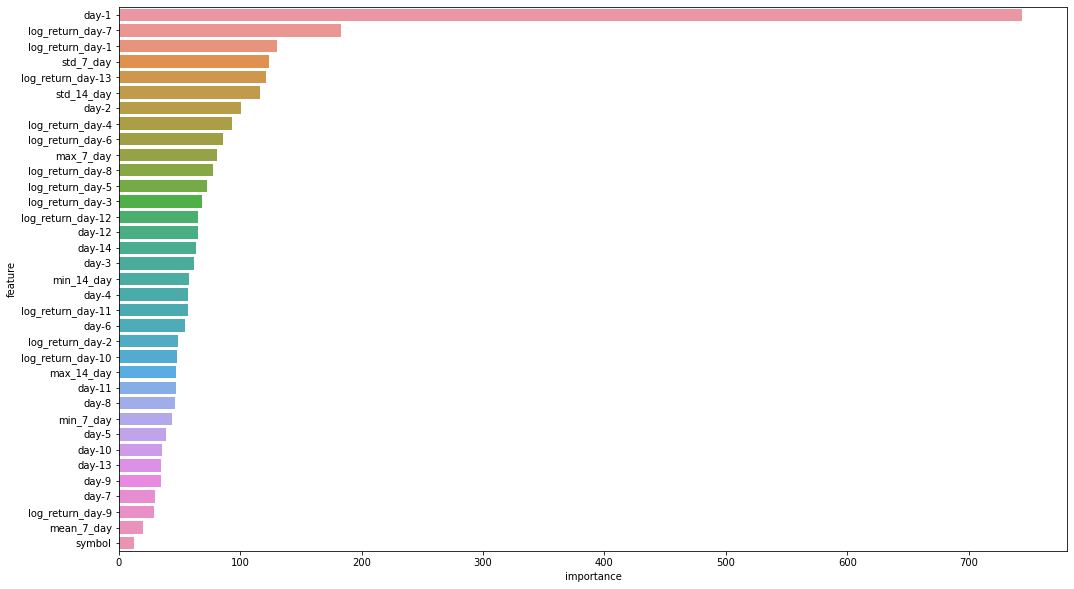

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)
plt.figure(figsize=(17,10))
sns.barplot(x='importance', y='feature', data=df_feature_importance)

## Predict

In [ ]:
future_dates = pd.date_range('2022-09-01', '2023-09-01')

In [ ]:
for date in future_dates:
    print(date)
    X_test = []
    X_test_symbol = []
    for symbol in symbols:
        feat_14_day = df_horizontal_symbols.tail(14)[symbol].to_list()
        feats = make_feature(feat_14_day)
        X_test.append(feats)
        X_test_symbol.append(symbol)
    X_test = pd.DataFrame(X_test)
    X_test.columns = column_names
    X_test['symbol'] = X_test_symbol
    X_test['symbol'] = X_test['symbol'].astype('category')
    nextday = pd.DataFrame({'symbol': symbols,
                        'Predicted': model.predict(X_test),
                        'date': [date]*len(symbols)})
    nextday_horizontal_symbols = pd.pivot_table(nextday,
               index = 'date',
               columns = 'symbol',
               values = 'Predicted',
               aggfunc = {
                   'Predicted': lambda x: x
               }
              )
    df_horizontal_symbols = pd.concat([df_horizontal_symbols, nextday_horizontal_symbols])

2022-09-01 00:00:00
2022-09-02 00:00:00
2022-09-03 00:00:00
2022-09-04 00:00:00
2022-09-05 00:00:00
2022-09-06 00:00:00
2022-09-07 00:00:00
2022-09-08 00:00:00
2022-09-09 00:00:00
2022-09-10 00:00:00
2022-09-11 00:00:00
2022-09-12 00:00:00
2022-09-13 00:00:00
2022-09-14 00:00:00
2022-09-15 00:00:00
2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00
2022-09-19 00:00:00
2022-09-20 00:00:00
2022-09-21 00:00:00
2022-09-22 00:00:00
2022-09-23 00:00:00
2022-09-24 00:00:00
2022-09-25 00:00:00
2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
2022-09-30 00:00:00
2022-10-01 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-05 00:00:00
2022-10-06 00:00:00
2022-10-07 00:00:00
2022-10-08 00:00:00
2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00


In [ ]:
df_horizontal_symbols.reset_index(inplace=True)
df_horizontal_symbols.rename(columns={'index':'date'},inplace=True)

In [ ]:
predictions = df_horizontal_symbols.melt(id_vars=['date'],value_name='Predicted')
predictions['Id'] = predictions['date'].astype(str) + ':' + predictions['symbol']

In [ ]:
test_price['Id'] = test_price['date'].astype(str) + ':' + test_price['symbol']
test_price = test_price.merge(predictions[['Id','Predicted']],how='left',on='Id')

## Add topping

In [ ]:
mean_all = ['HPG','HSG','DTL']
others = set(symbols)  - set(mean_all)
mean_full_predict = train_price[train_price['symbol'].isin(mean_all)].groupby(['symbol'])['close'].apply(lambda x: np.mean(list(x))).reset_index()
mean_full_predict.columns = ['symbol', 'topping']
mean_last14_predict = train_price[train_price['symbol'].isin(others)].groupby(['symbol'])['close'].apply(lambda x: np.mean(list(x)[-14:])).reset_index()
mean_last14_predict.columns = ['symbol', 'topping']

In [ ]:
topping = pd.concat([mean_full_predict, mean_last14_predict],axis=0).fillna(0)

In [ ]:
test_price = test_price.merge(topping,how='left',on='symbol')

In [ ]:
test_price['Predicted'] = (test_price['Predicted'] + test_price['topping']) / 2

In [ ]:
test_price[['Id','Predicted']].to_csv('sub.csv',index=False)